In [11]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingEdges import *
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

In [ ]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "C:\\Users\\micha\\Documents\\Imperial Courses\\Thesis\\IAEA-thesis\\data\\swde\\sourceCode\\sourceCode\\movie\\movie\\movie-allmovie(2000)\\0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

In [ ]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)

In [ ]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s"), normalise_text(b, "%'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [ ]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=64)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

blog
explore
learn more about how westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
learn more
join our team
access our custom technology library designed for nuclear engineering students and professionals
x click on the background to close the video
take a look
learn more watch video
read more
france french
learn more about why databricks selected westinghouse ai for its 2025 data intelligence in energy utility award
explore now
explore careers
explore our interactive 3d visualization tool for innovative answers to operating plant challenges


In [ ]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [ ]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

2256  ->  127


In [ ]:
# Classify the edges
classification = classify_link_pairs_flan_batched(txts, batch_size=64)

In [ ]:
if len(classification) != len(txts):
    raise Exception("The classification is not the same length as the number of edges")
for idx, theClass in enumerate(classification):
    print(theClass, txts[idx])

2 ['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology']
2 ['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr']
5 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator']
3 ['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
2 ['evinci microreactor'
 'the next generation small modular reactor for remote applications']
2 ['the next generation small modular reactor for remote applications'
 'evinci microreactor']
5 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq']
3 ['westinghouseiq'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
2 ['when it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy with nuclear power you

['solar wind and nuclear energy are essential to a carbonfree future but the sun doesnt always shine and the wind doesnt always blow nuclear power plants are almost always on delivering the highest availability energy source and operating at maximum capacity more than 90% of the time'
 'shaping the future with reliable energy']
['shaping the future with reliable energy'
 'solar wind and nuclear energy are essential to a carbonfree future but the sun doesnt always shine and the wind doesnt always blow nuclear power plants are almost always on delivering the highest availability energy source and operating at maximum capacity more than 90% of the time']
['balancing wind solar and nuclear power will help achieve a carbonfree future and positively impact our changing climate over the past 50 years globally nuclear power has avoided nearly two years of the worlds energyrelated co2 emissions imagine how much more carbon pollution we can prevent'
 'nuclear energyprovides 55% of the uss and 14

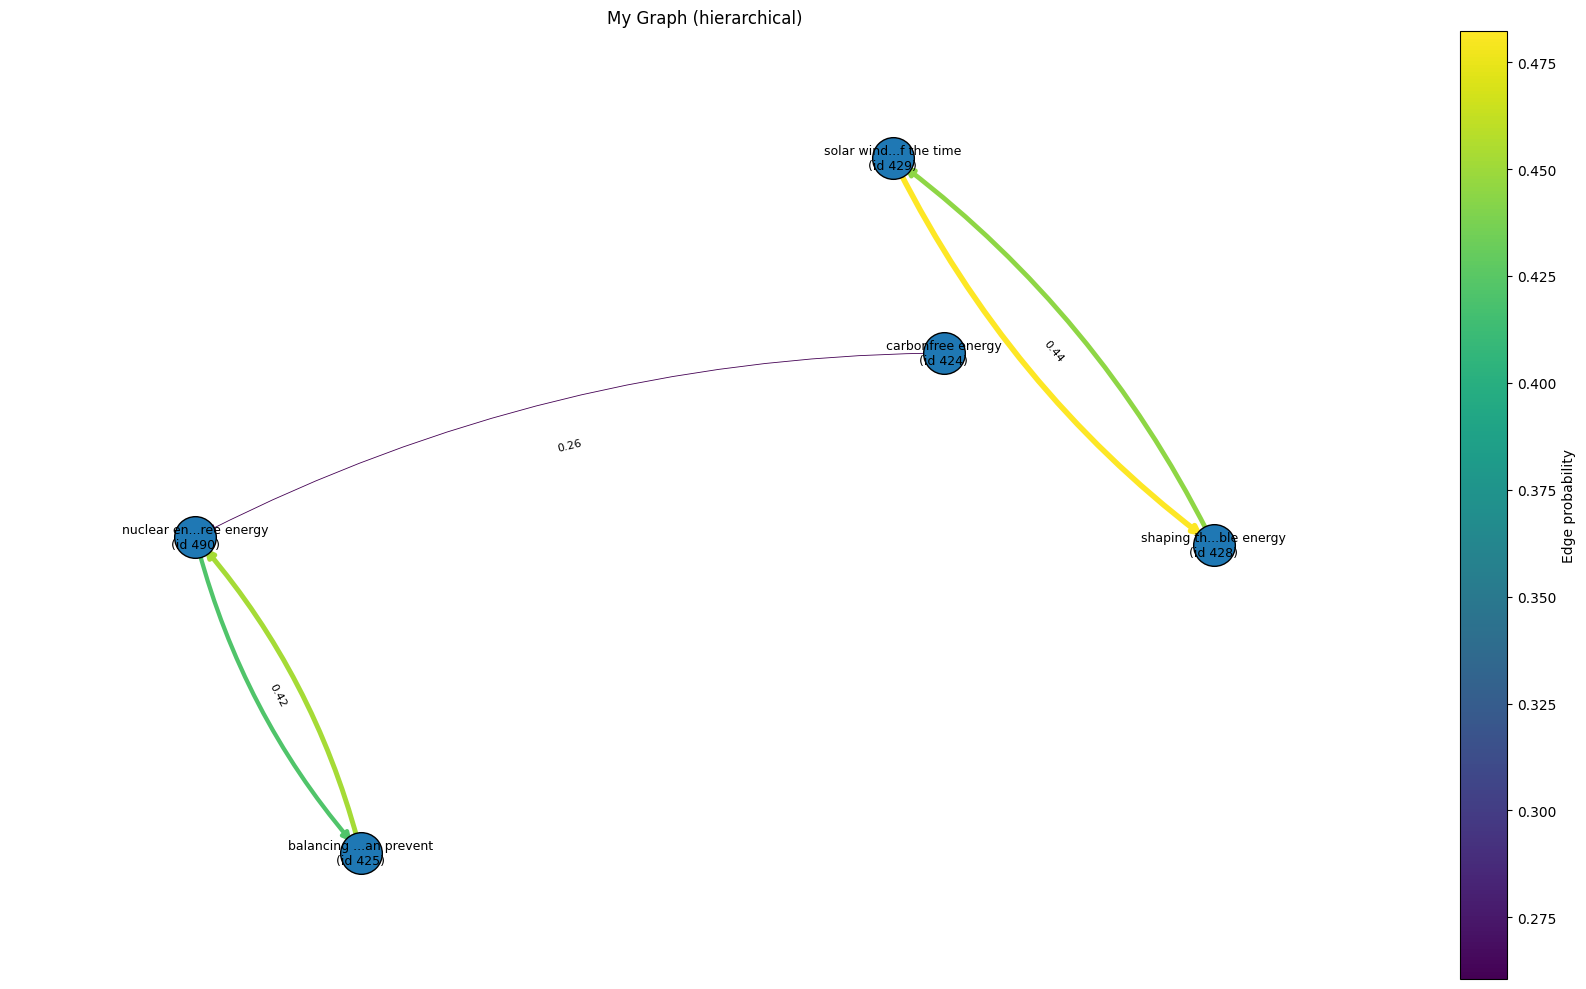

{'G': <networkx.classes.digraph.DiGraph at 0x756d5bee9d60>,
 'pos': {429: array([0.32594159, 0.84931199]),
  428: array([ 0.93628359, -0.14212728]),
  425: array([-0.68523468, -0.9318727 ]),
  490: array([-1.        , -0.12395233]),
  424: array([0.42300949, 0.34864032])},
 'fig': <Figure size 1600x1000 with 2 Axes>,
 'ax': <Axes: title={'center': 'My Graph (hierarchical)'}>}

In [ ]:
# Display the graph
#textmask = np.array([True]*len(txts))
textmask = filterTextMask(txts, "%", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)